In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet
from lib.sampling import get_slides
size=512
path = Path('./')

database = Database()
database.open(str(path/'./databases/MITOS_WSI_CMC_CODAEL_TR.sqlite'))

slidelist_test_1 = ['14','18','3','22','10','15','21']
slidelist_test_2 = ['1','20','17','5','2','11','16']
slidelist_test_3 = ['13','7','19','8','6','9', '12']
slidelist_test = slidelist_test_1

## Split dataset into train/validation and test on slide level

Convert database into in-memory object

In [2]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, negative_class=1,  size=size,database=database,basepath='./WSI')

Loading slides .. : 100%|██████████| 21/21 [00:03<00:00,  6.82it/s]


In [3]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [4]:
bs = 12
train_images = 5000
val_images = 5000

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))


In [5]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )


In [6]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

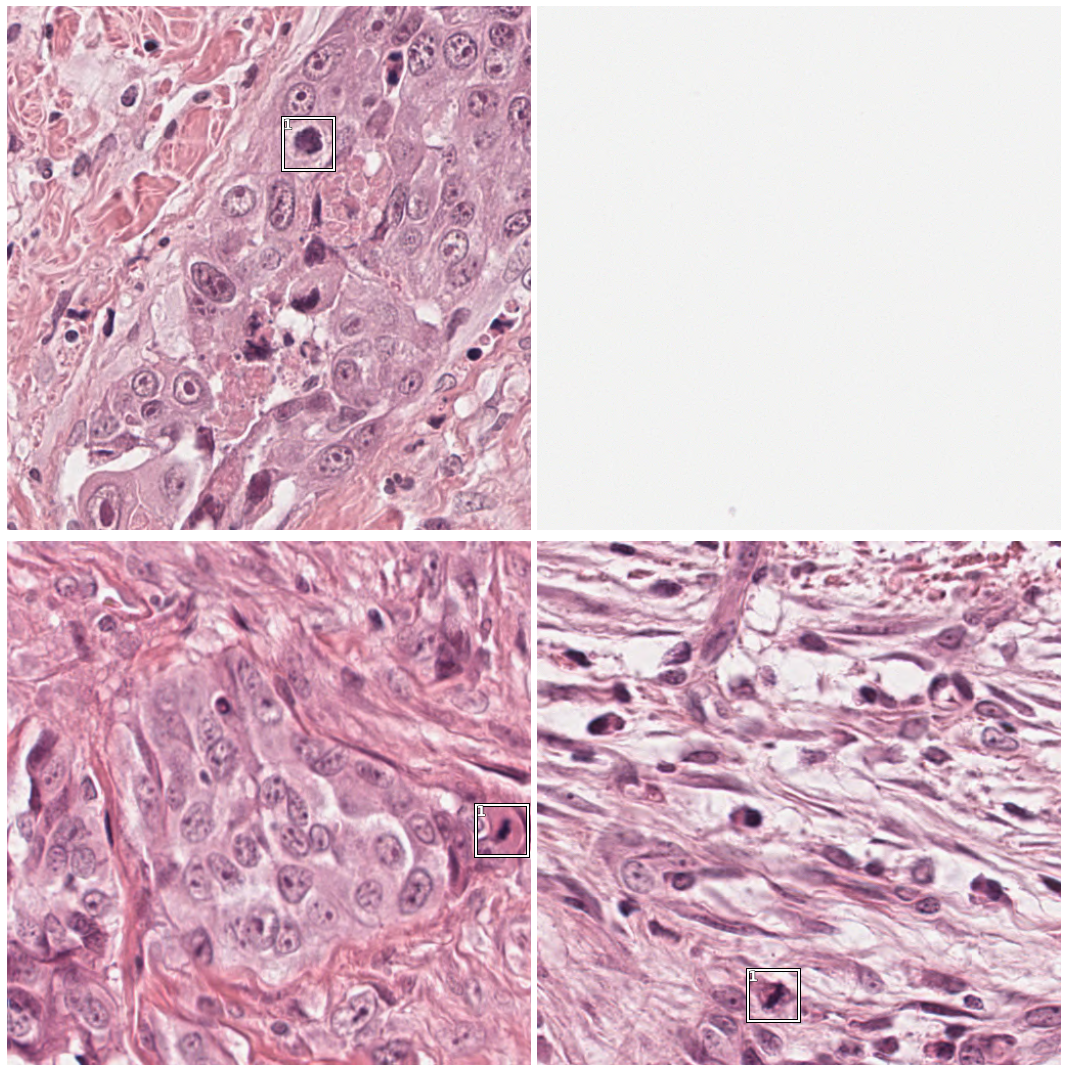

In [7]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(15,15))

In [8]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7,0.8])


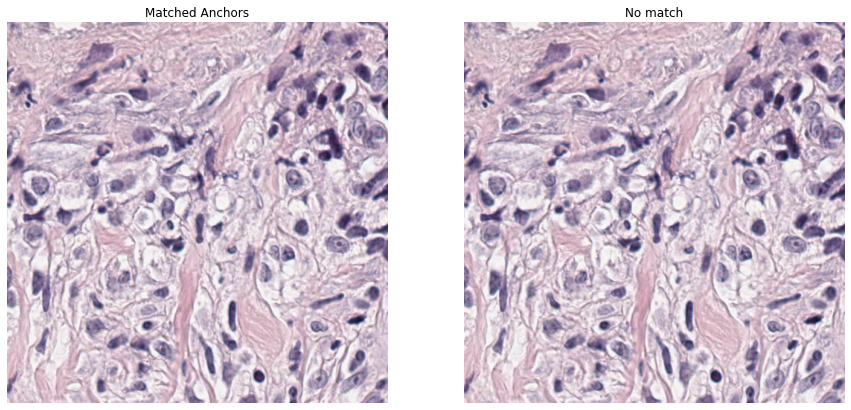

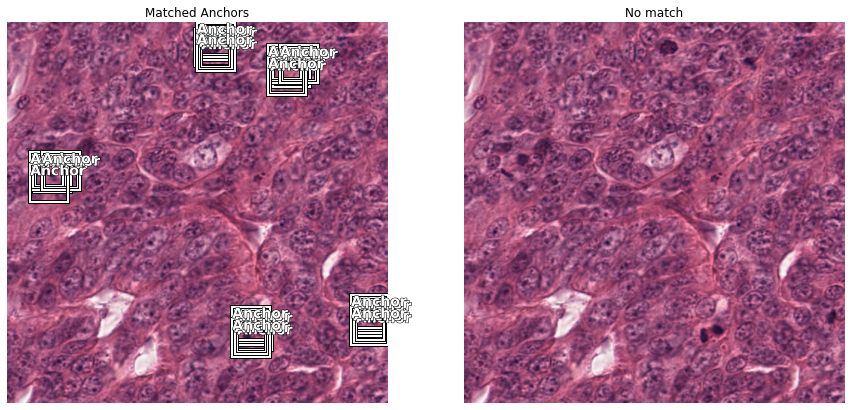

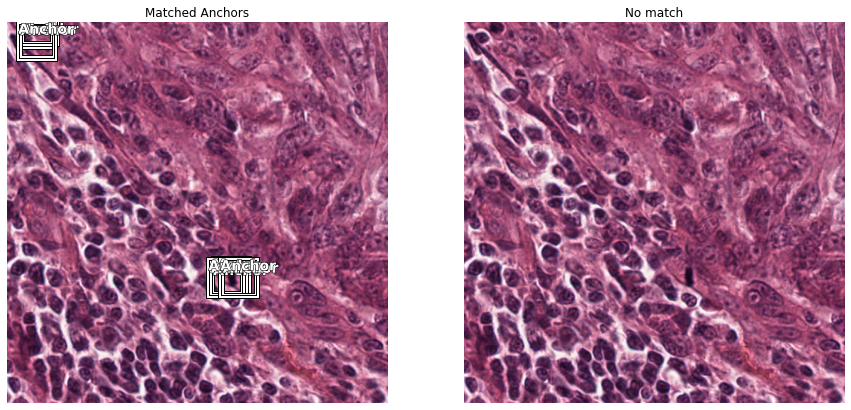

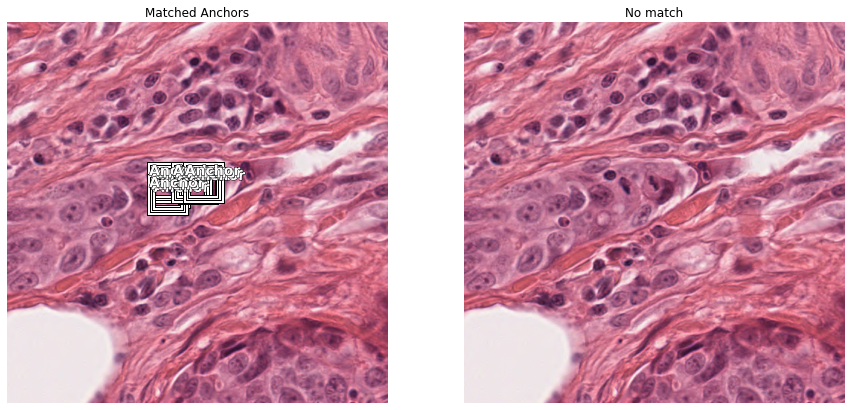

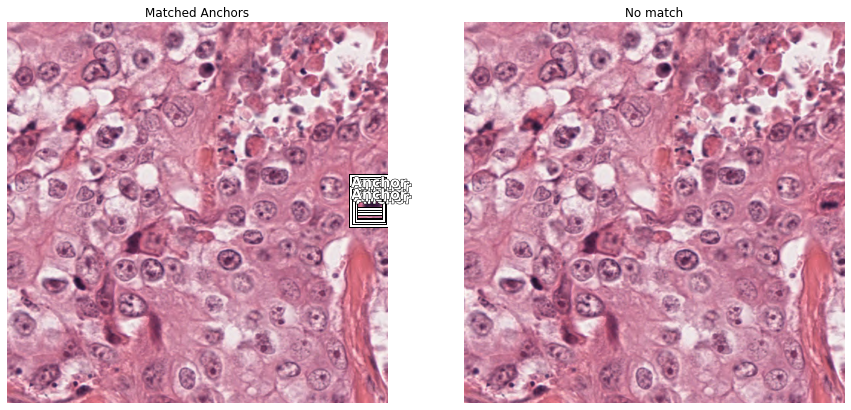

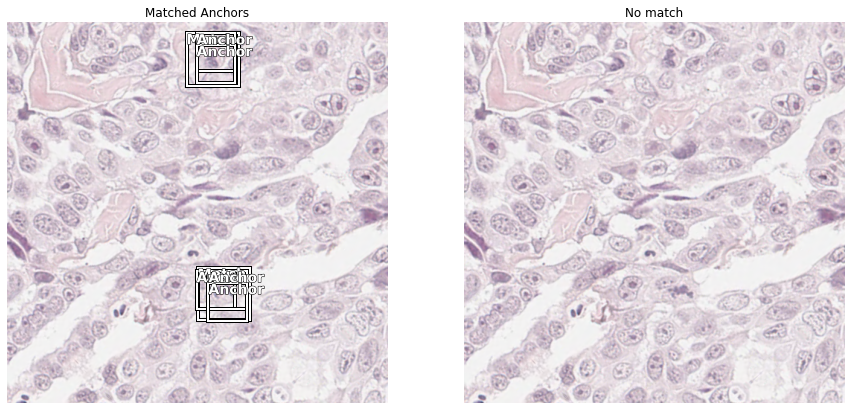

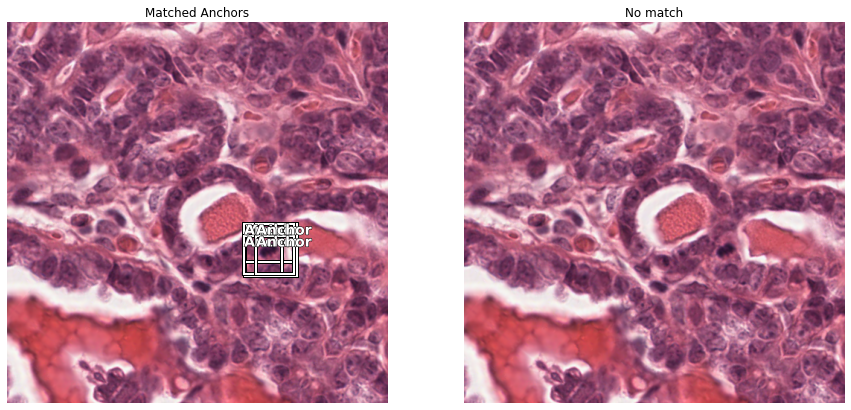

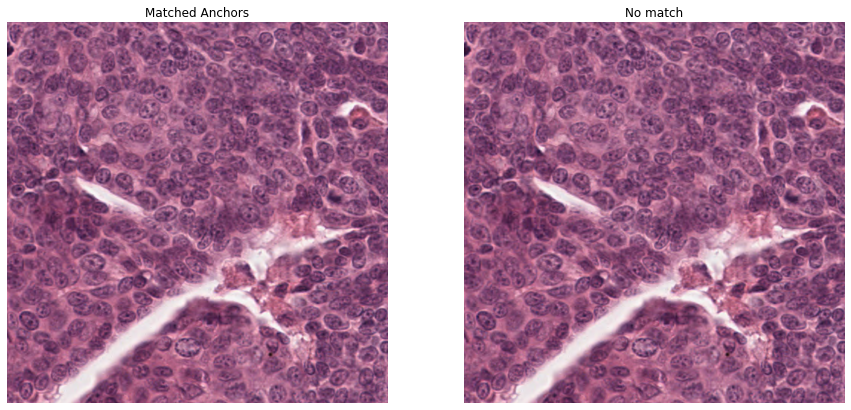

In [9]:
not_found = show_anchors_on_images(data, anchors)

In [10]:
crit = RetinaNetFocalLoss(anchors)

In [11]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[32], chs=128, final_bias=-4., n_conv=3)



In [12]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [13]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


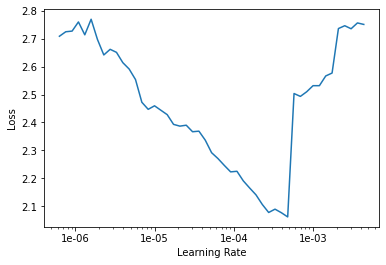

In [14]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 2803/2803 [00:00<00:00, 3692.63it/s]


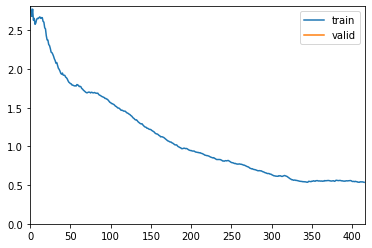

In [15]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 2689/2689 [00:00<00:00, 3764.87it/s]


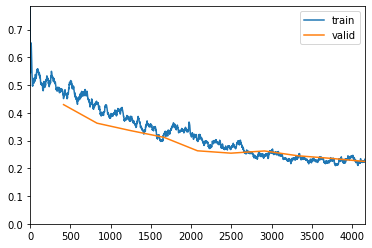

GT: 100%|██████████| 2882/2882 [00:00<00:00, 4261.74it/s]


In [16]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

GT: 100%|██████████| 2892/2892 [00:00<00:00, 4191.34it/s]


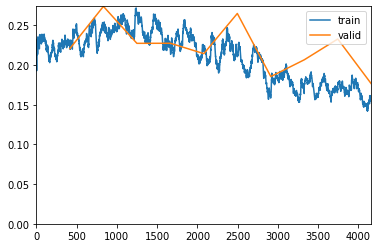

GT: 100%|██████████| 2943/2943 [00:00<00:00, 3951.33it/s]


In [17]:
learn.unfreeze()
lr=1e-4

learn.fit_one_cycle(10, lr)

GT: 100%|██████████| 2878/2878 [00:00<00:00, 3918.66it/s]


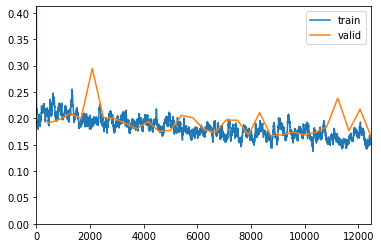

Better model found at epoch 0 with valid_loss value: 0.19080665707588196.


GT: 100%|██████████| 2920/2920 [00:00<00:00, 4260.48it/s]


Better model found at epoch 7 with valid_loss value: 0.19021537899971008.


GT: 100%|██████████| 2941/2941 [00:00<00:00, 3826.31it/s]


Better model found at epoch 8 with valid_loss value: 0.18022873997688293.


GT: 100%|██████████| 2908/2908 [00:00<00:00, 4098.19it/s]


Better model found at epoch 10 with valid_loss value: 0.17526212334632874.


GT: 100%|██████████| 2907/2907 [00:00<00:00, 4159.24it/s]


Better model found at epoch 15 with valid_loss value: 0.17302672564983368.


GT: 100%|██████████| 2902/2902 [00:00<00:00, 4266.61it/s]


Better model found at epoch 18 with valid_loss value: 0.16877268254756927.


GT: 100%|██████████| 2915/2915 [00:00<00:00, 3922.13it/s]


Better model found at epoch 20 with valid_loss value: 0.16695578396320343.


GT: 100%|██████████| 2960/2960 [00:00<00:00, 3995.88it/s]


Better model found at epoch 29 with valid_loss value: 0.16445888578891754.


In [18]:
learn.unfreeze()
lr=1e-4

learn.fit(30, lr, callbacks=[SaveModelCallback(learn, every='improvement', name='model')])

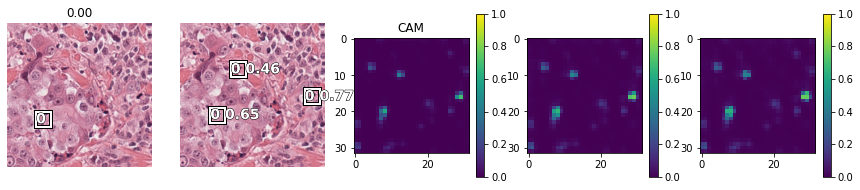

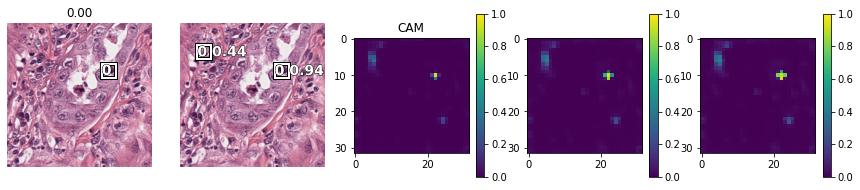

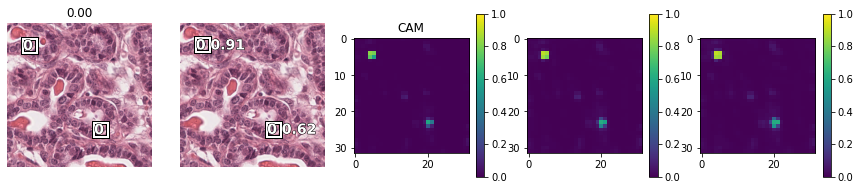

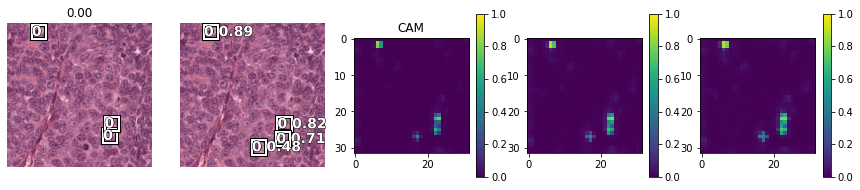

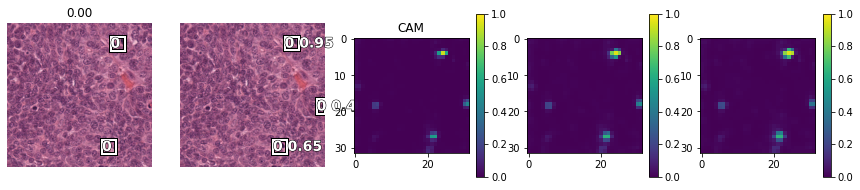

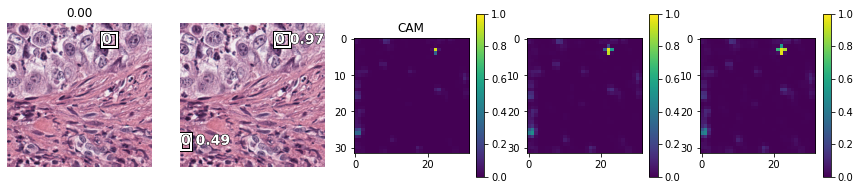

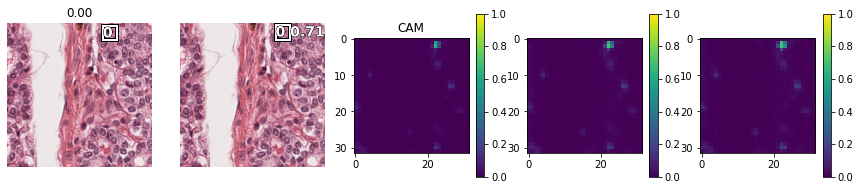

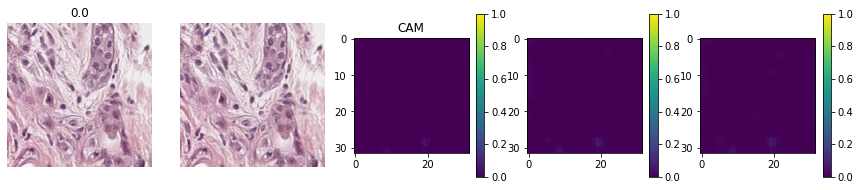

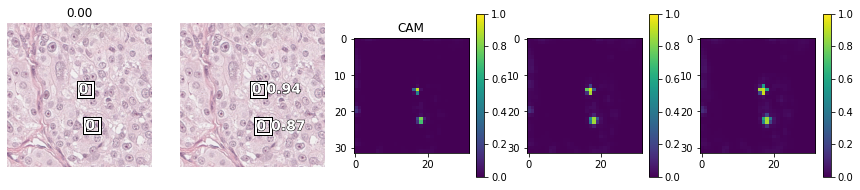

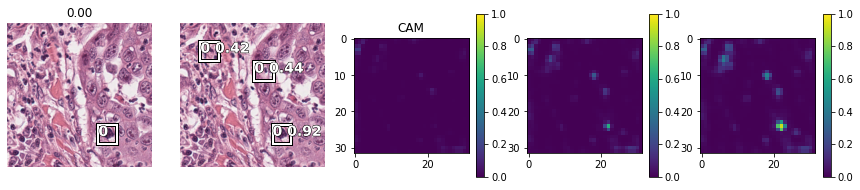

In [19]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [20]:
learn.save('RetinaNet-CMC-CODAEL-512sh-batch1', with_opt=True)
learn.export("RetinaNet-CMC-CODAEL-512sh-b1.pth")

In [21]:
torch.save(learn.model.state_dict(), "RetinaNet-CMC-CODAEL-512sh-batch1_statedict.pth")

In [22]:
learn.data.stats

[tensor([0.8162, 0.6784, 0.7419]), tensor([0.1514, 0.2390, 0.1875])]